In [ ]:
!pip install kaggle==1.5.6

In [ ]:
# Создаем путь (использовался API token)
! mkdir ~/.kaggle # создаем директорию

! cp kaggle.json ~/.kaggle/ # подгружаем туда ключ с kaggle

! chmod 600 ~/.kaggle/kaggle.json # даем разрешение

In [ ]:
# Загружаем данные
! kaggle competitions download -c journey-springfield

 98% 508M/521M [00:04<00:00, 129MB/s]
100% 521M/521M [00:04<00:00, 112MB/s]


In [ ]:
# Распаковываем архив
!unzip -q /content/journey-springfield.zip

In [ ]:
import torchvision
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Функция для применения паддинга
RESCALE_SIZE = 224

def _prepare_sample(image):
        # наставляет паддинг, чтобы не изменялись пропорции изображения
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)

        image = transforms.functional.pad(image, padding, 0, 'constant')
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomGrayscale(0.1),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomAdjustSharpness(0.2),
        transforms.RandomApply(nn.ModuleList([transforms.GaussianBlur(5)]), p=0.5),
        transforms.Lambda(lambda x: _prepare_sample(x)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Lambda(lambda x: _prepare_sample(x)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = './train/simpsons_dataset'

image_datasets = {x: datasets.ImageFolder(data_dir,
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
class_names

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers']

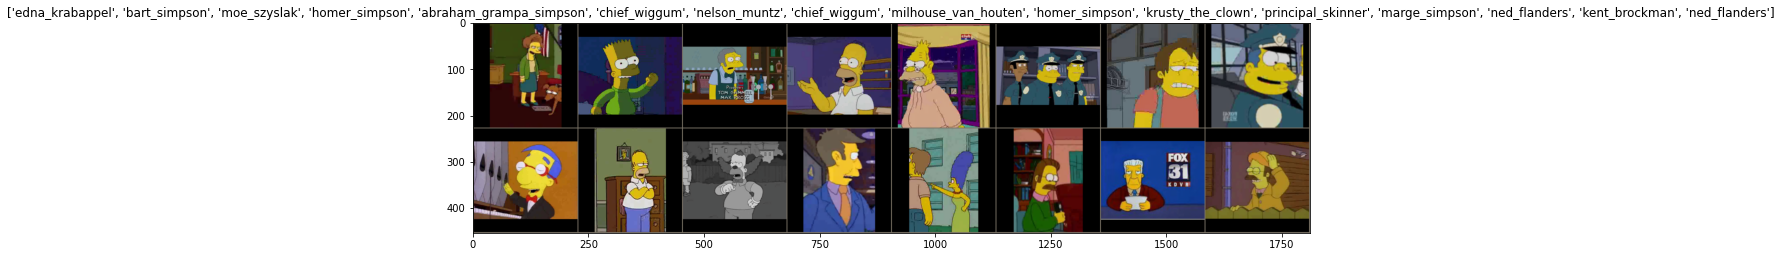

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 17))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#Тренировка модели
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Визуализация с предсказаниями
def visualize_model(model, num_images=16):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 42)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Обучение модели с разными lr
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5957 Acc: 0.8535
val Loss: 0.6135 Acc: 0.8319

Epoch 1/4
----------
train Loss: 0.2466 Acc: 0.9344
val Loss: 0.2940 Acc: 0.9162

Epoch 2/4
----------
train Loss: 0.1690 Acc: 0.9539
val Loss: 0.2164 Acc: 0.9424

Epoch 3/4
----------
train Loss: 0.1231 Acc: 0.9662
val Loss: 0.2566 Acc: 0.9281

Epoch 4/4
----------
train Loss: 0.0981 Acc: 0.9731
val Loss: 0.1219 Acc: 0.9656

Training complete in 36m 28s
Best val Acc: 0.965557


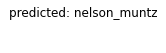

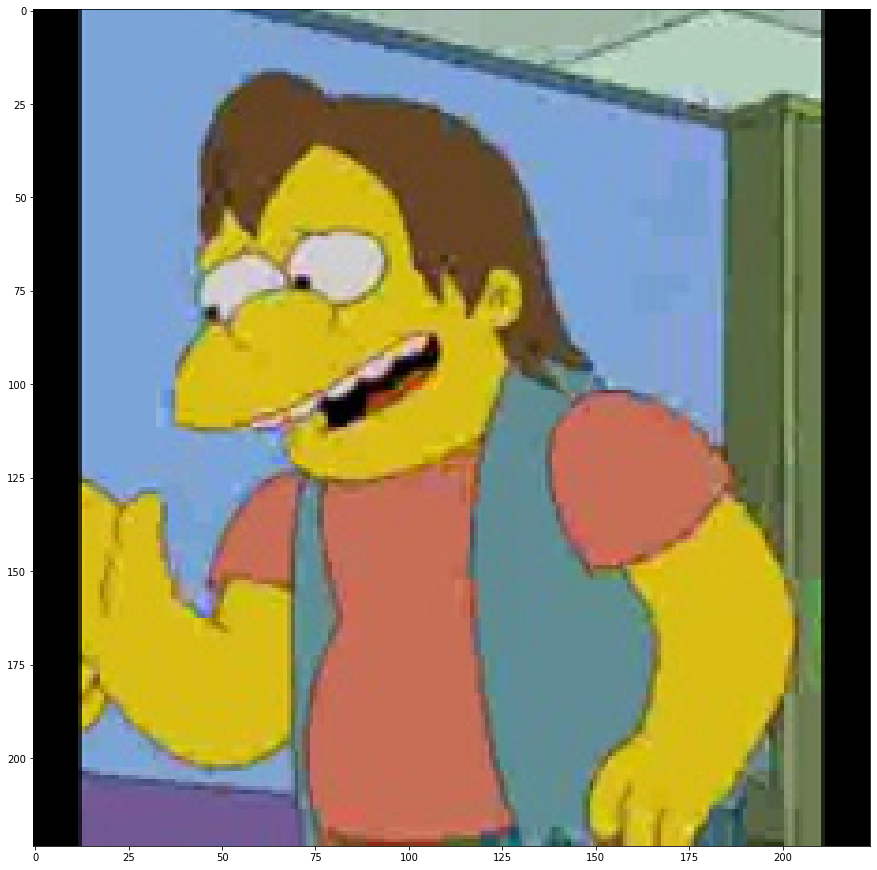

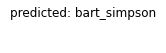

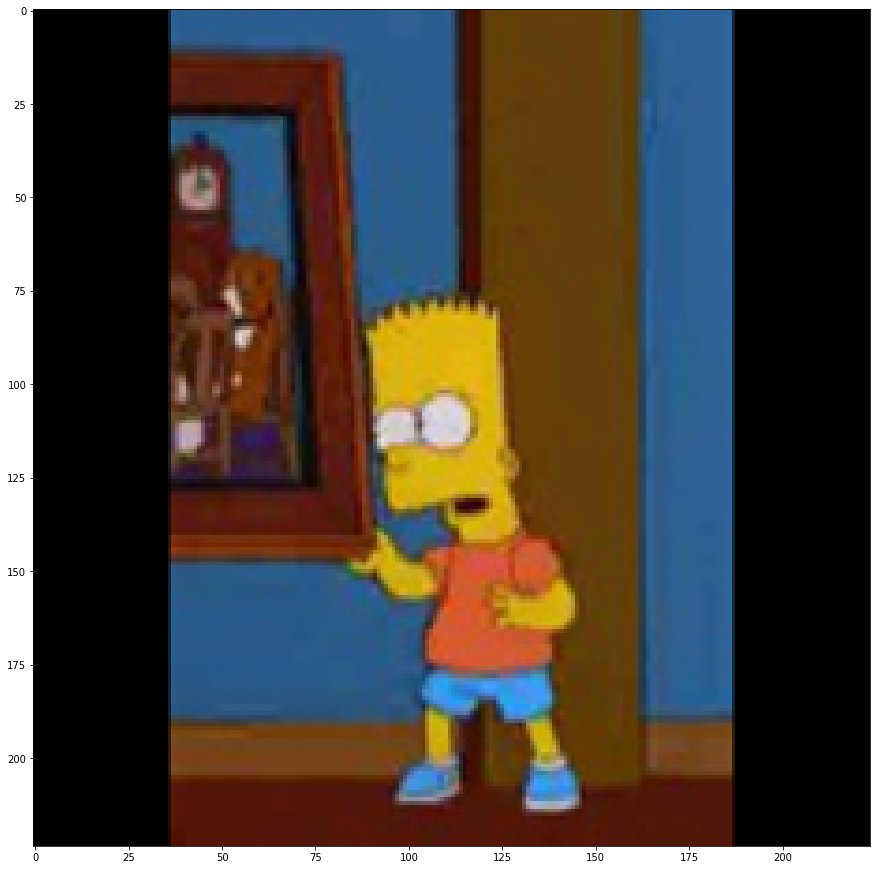

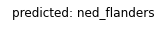

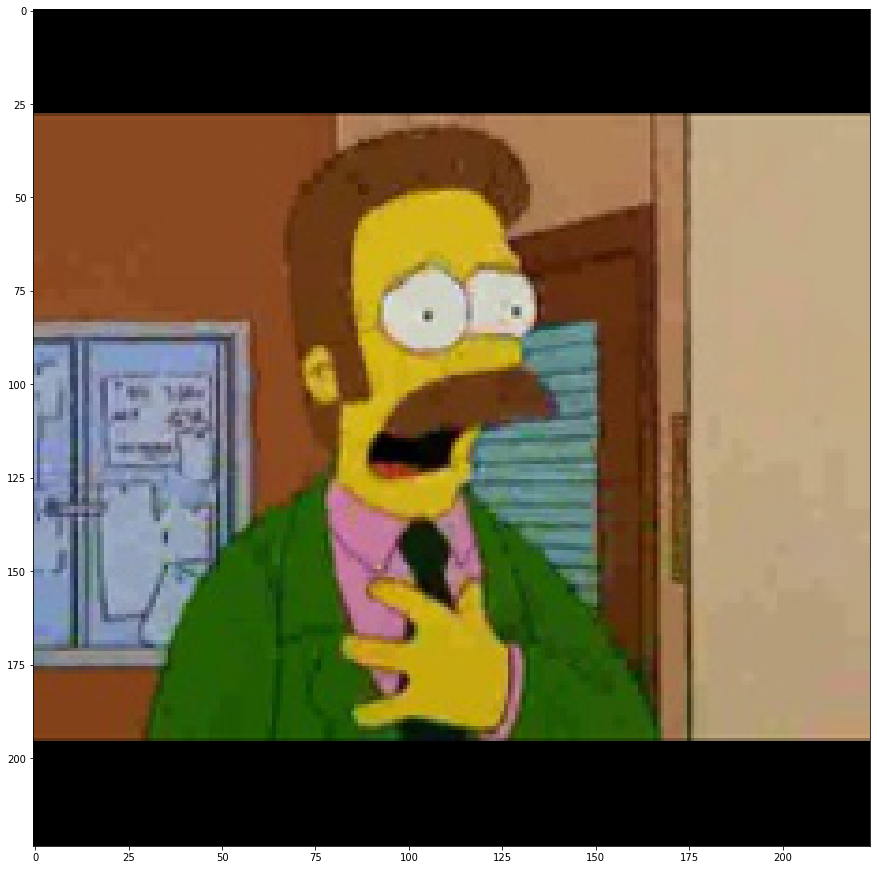

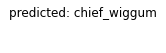

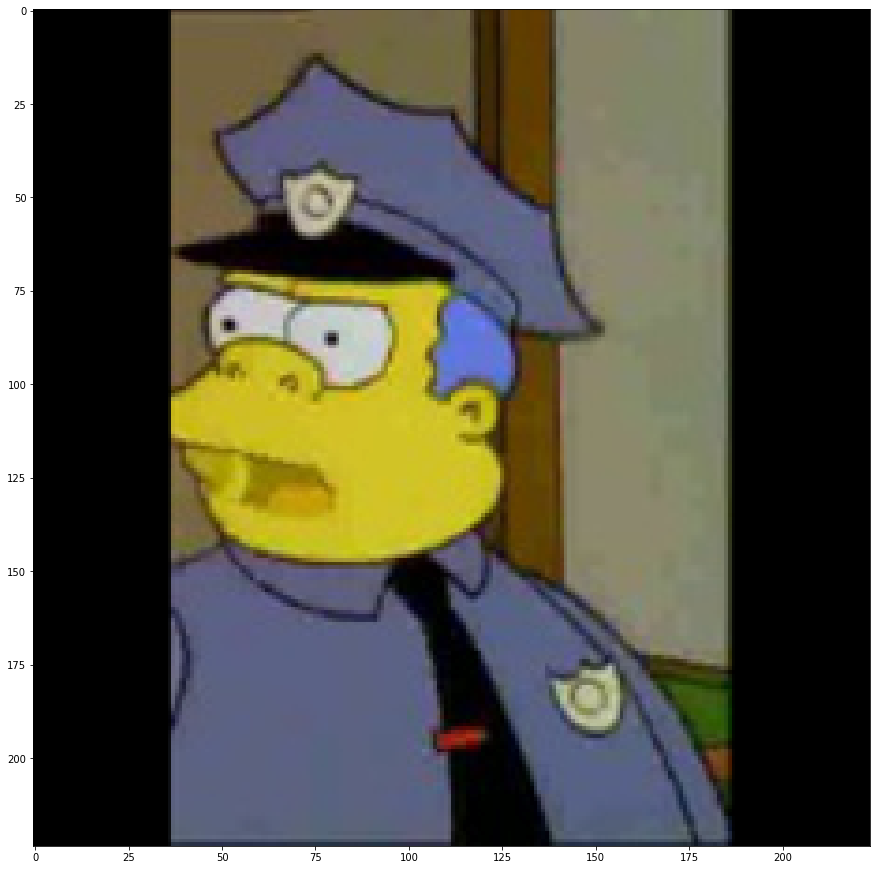

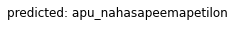

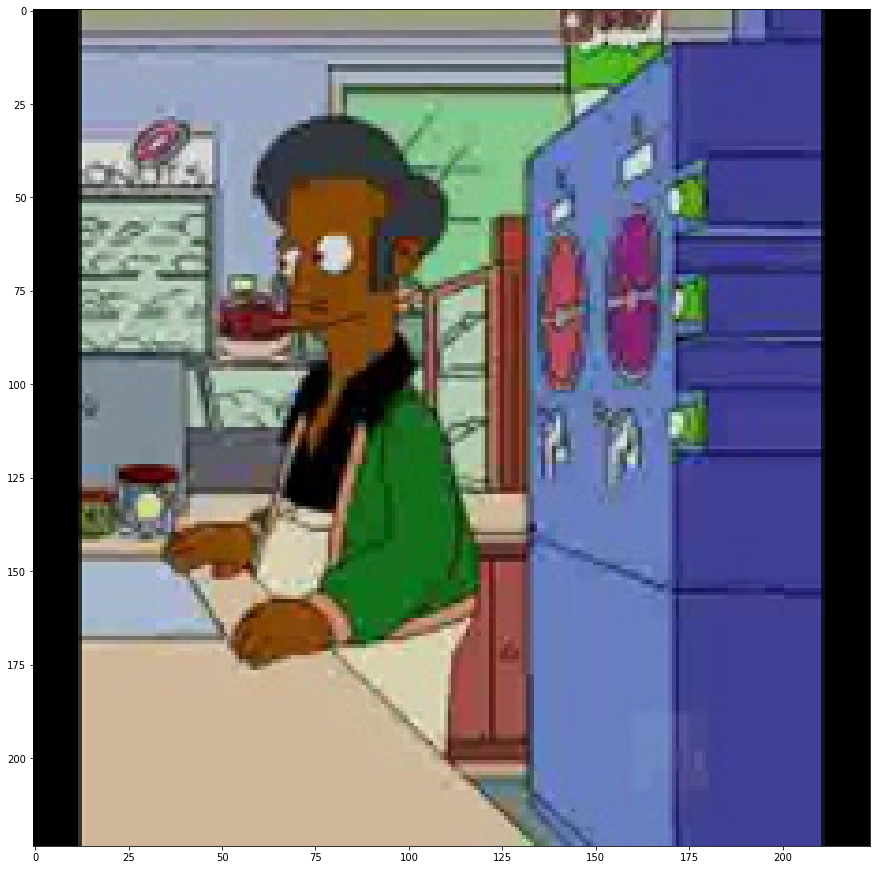

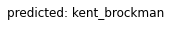

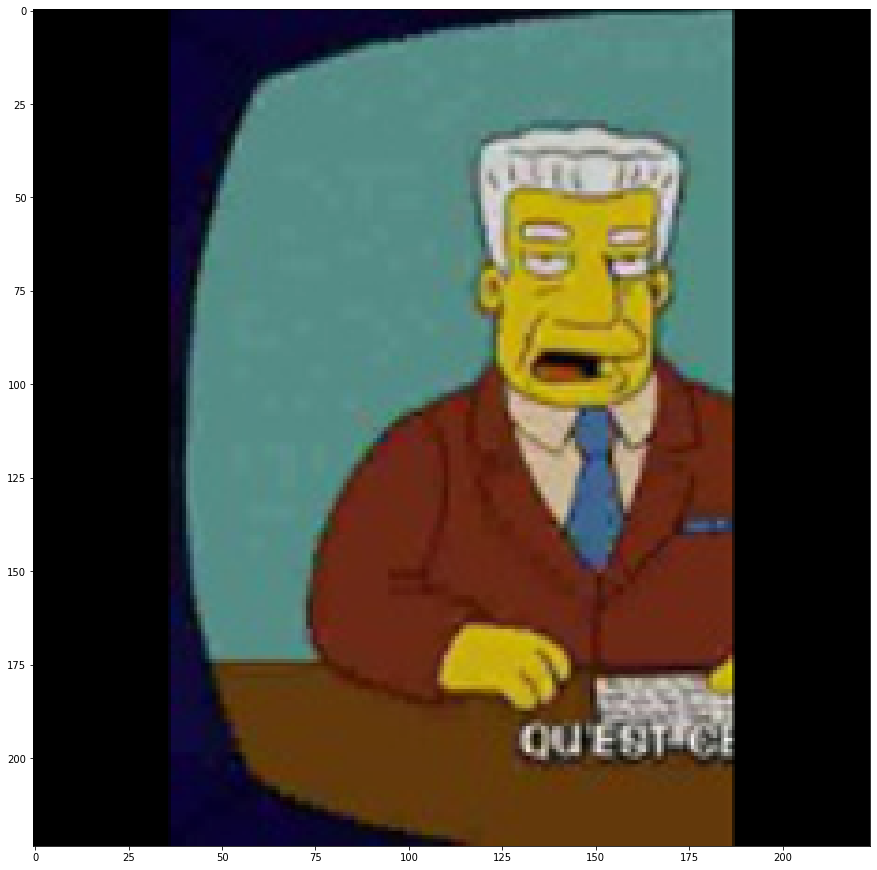

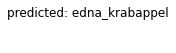

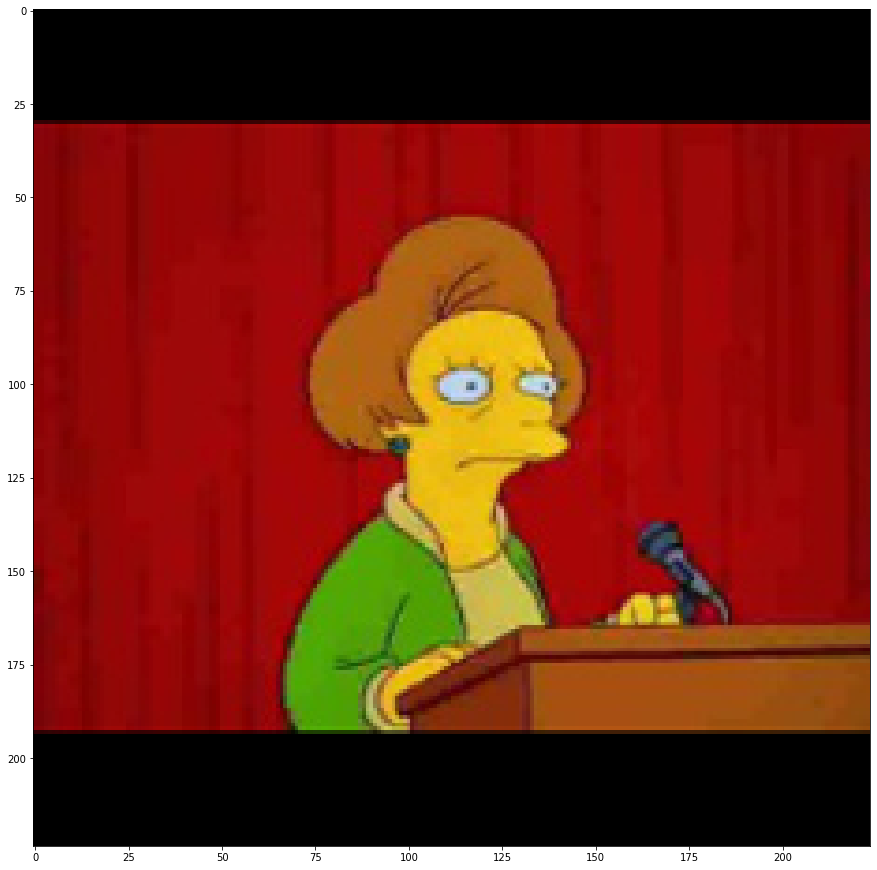

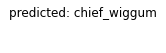

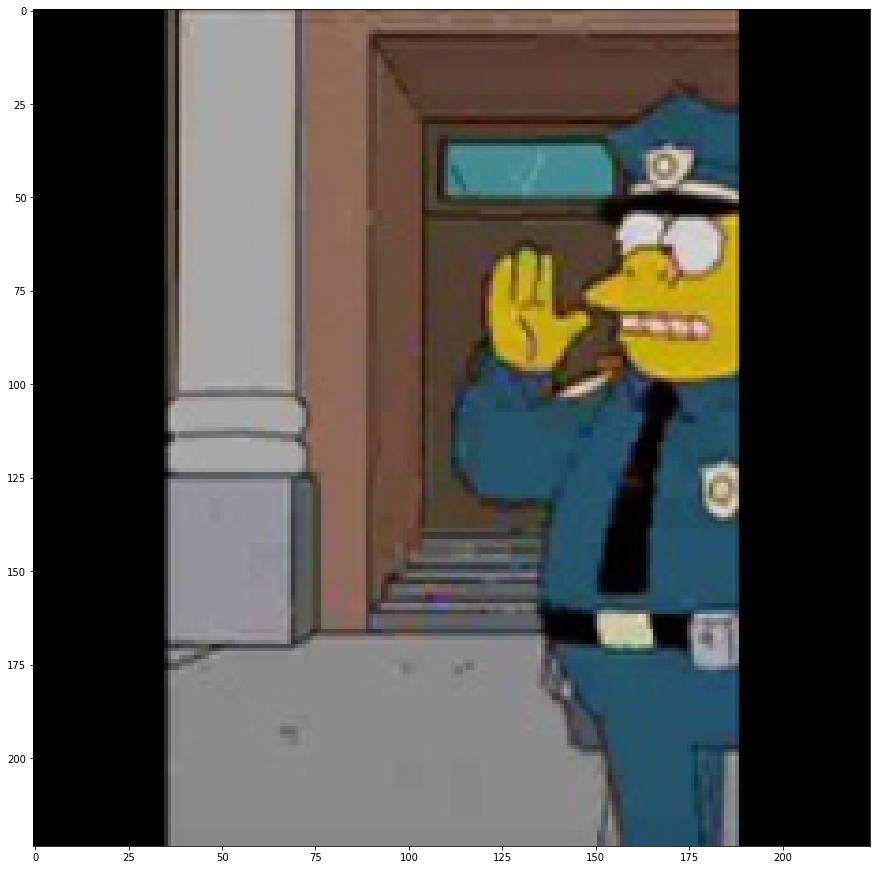

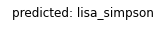

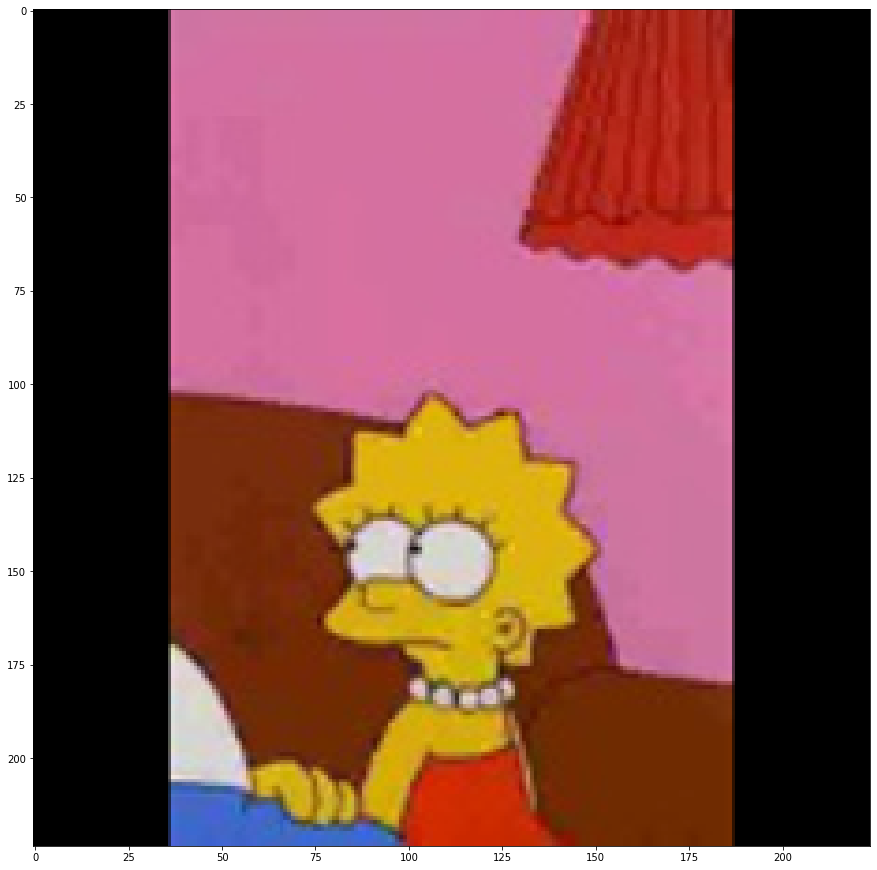

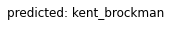

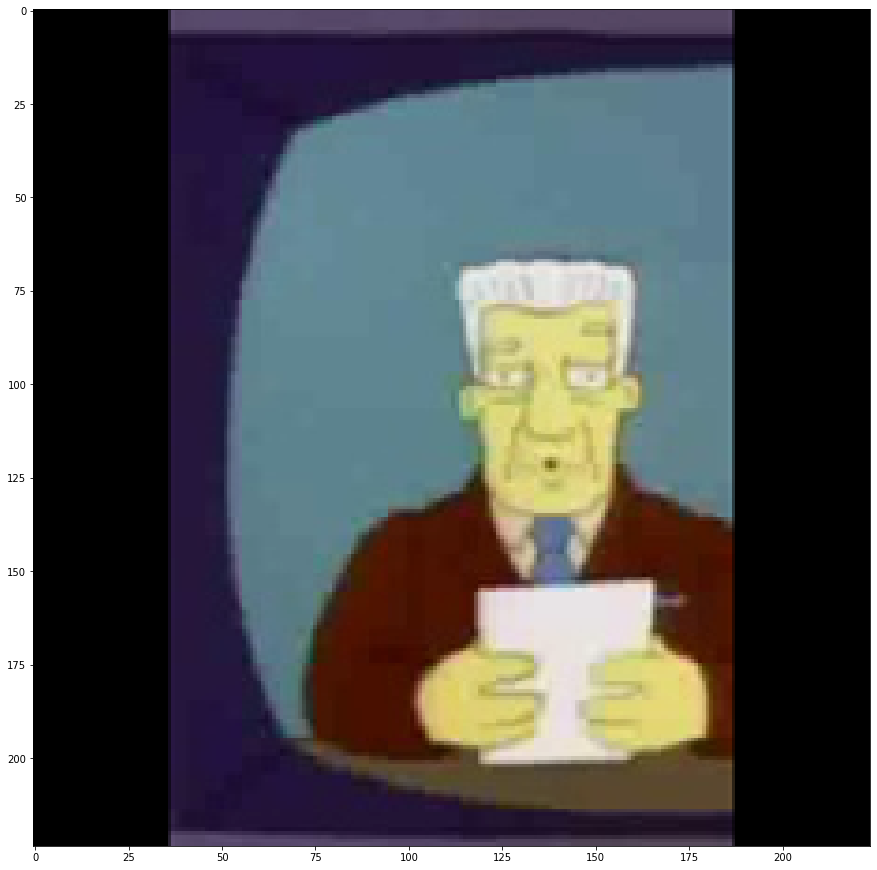

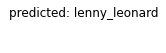

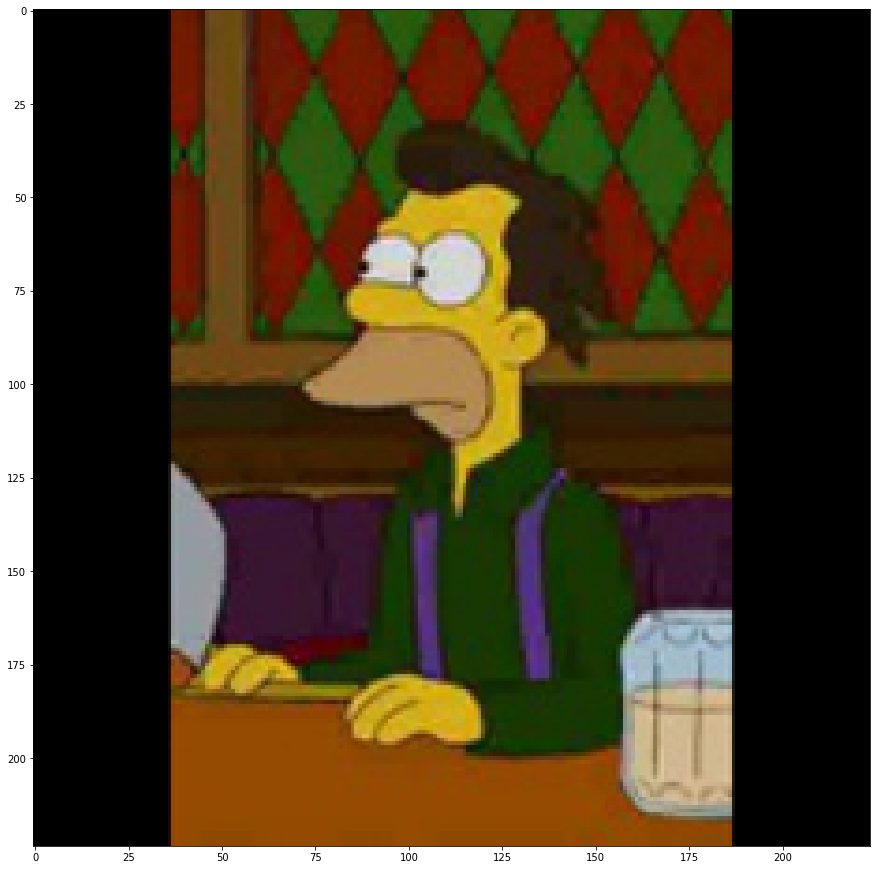

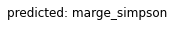

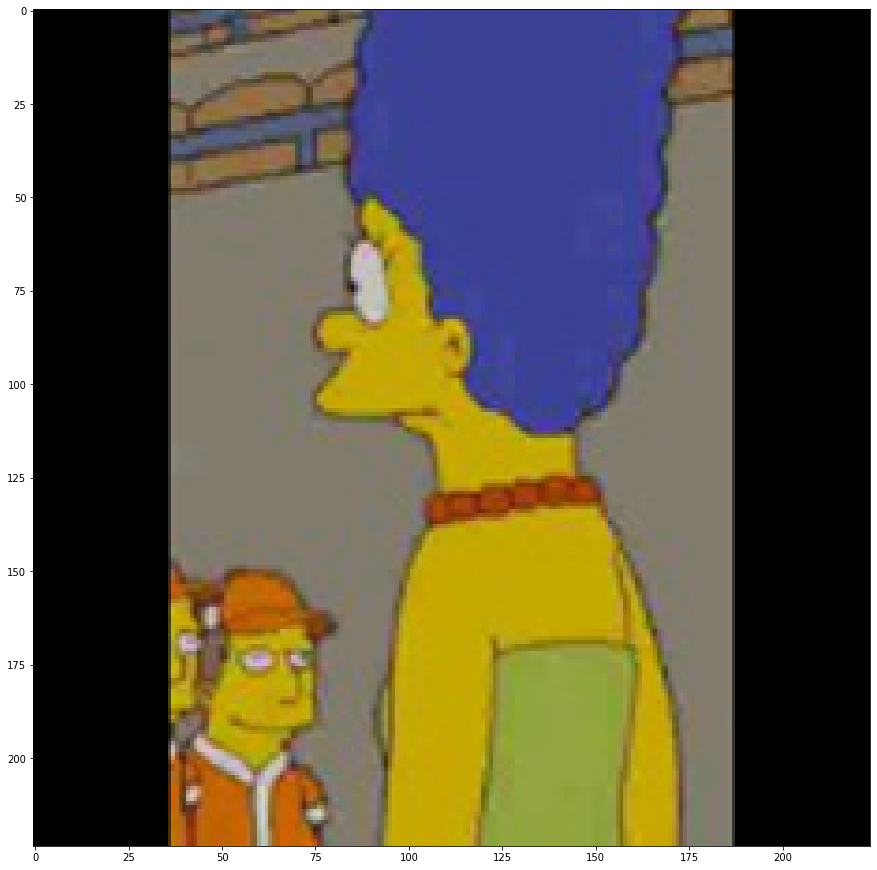

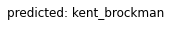

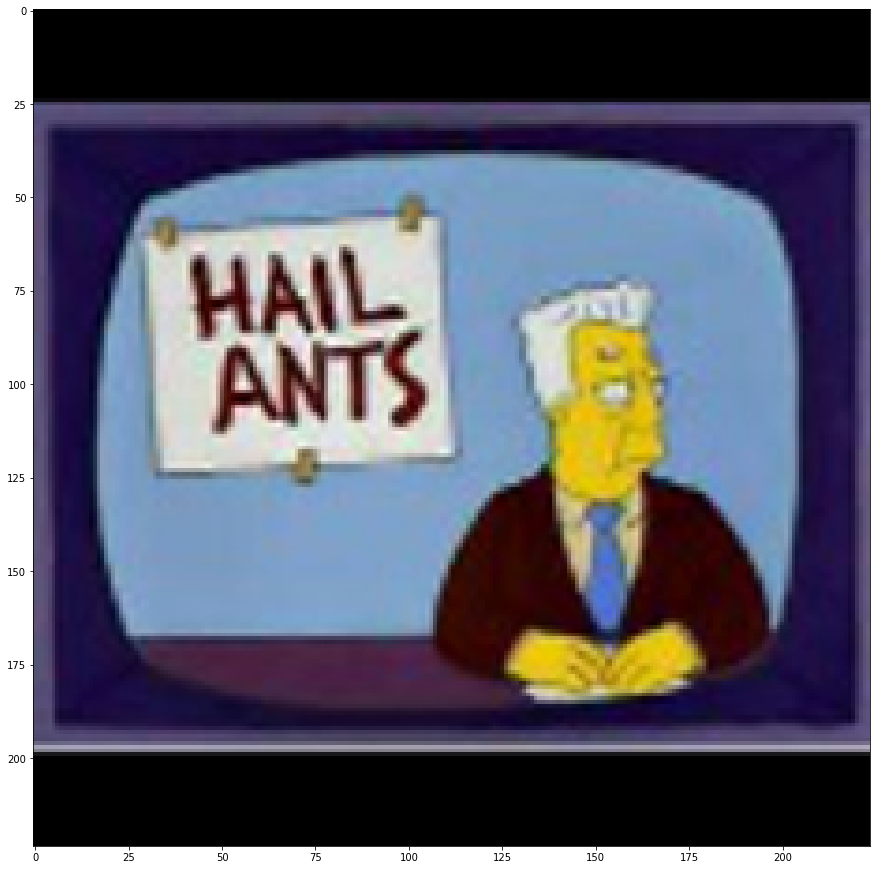

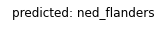

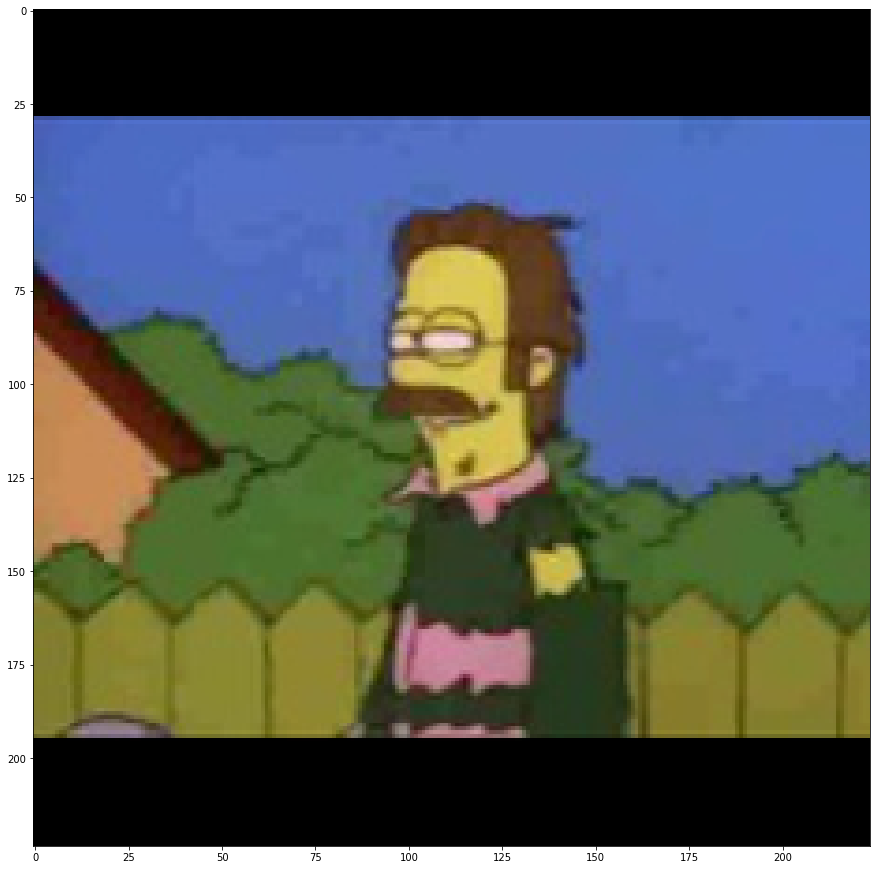

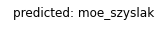

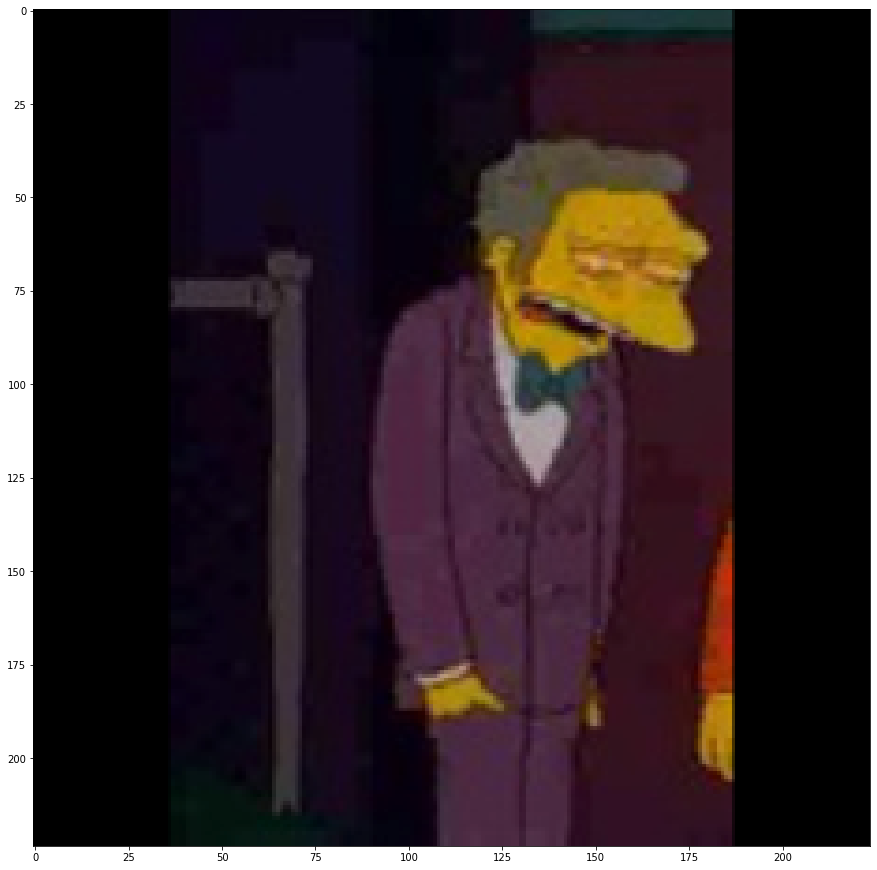

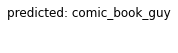

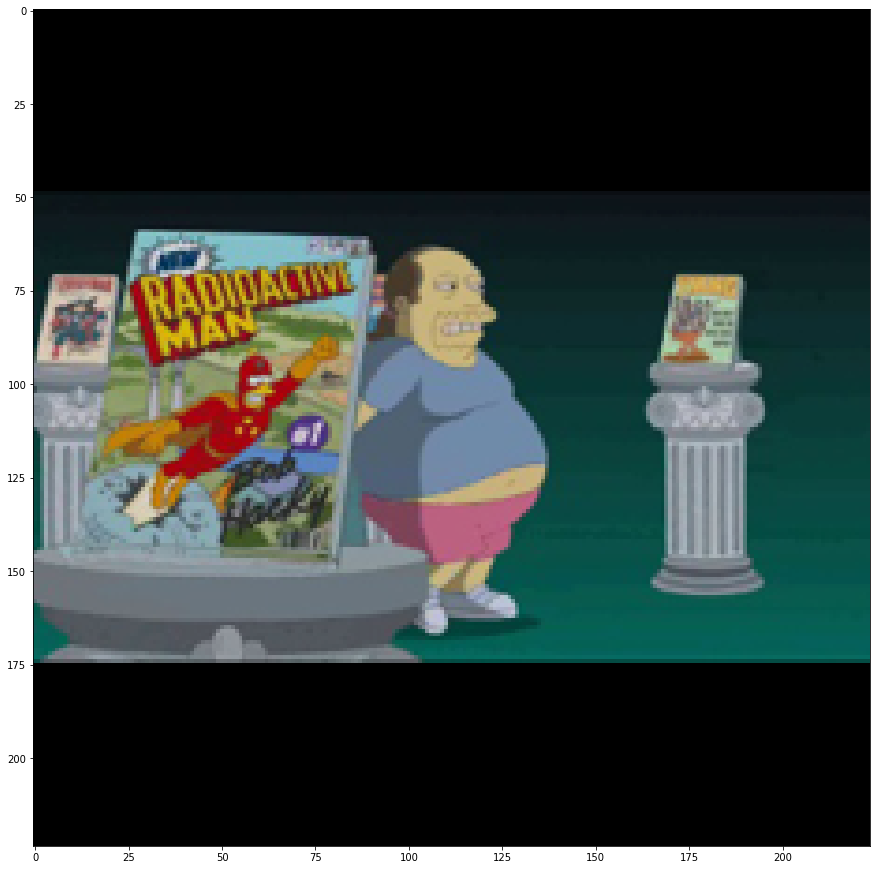

In [ ]:
visualize_model(model_ft)

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer = torch.optim.AdamW([
        {"params": model_ft.fc.parameters(), "lr": 3e-5}
        ],
        lr=1e-7
)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0796 Acc: 0.9784
val Loss: 0.0511 Acc: 0.9866

Epoch 1/9
----------
train Loss: 0.0747 Acc: 0.9796
val Loss: 0.0480 Acc: 0.9876

Epoch 2/9
----------
train Loss: 0.0715 Acc: 0.9814
val Loss: 0.0451 Acc: 0.9884

Epoch 3/9
----------
train Loss: 0.0713 Acc: 0.9811
val Loss: 0.0435 Acc: 0.9886

Epoch 4/9
----------
train Loss: 0.0721 Acc: 0.9805
val Loss: 0.0422 Acc: 0.9894

Epoch 5/9
----------
train Loss: 0.0646 Acc: 0.9844
val Loss: 0.0416 Acc: 0.9893

Epoch 6/9
----------
train Loss: 0.0635 Acc: 0.9841
val Loss: 0.0401 Acc: 0.9900

Epoch 7/9
----------
train Loss: 0.0644 Acc: 0.9822
val Loss: 0.0398 Acc: 0.9901

Epoch 8/9
----------
train Loss: 0.0608 Acc: 0.9843
val Loss: 0.0391 Acc: 0.9901

Epoch 9/9
----------
train Loss: 0.0597 Acc: 0.9838
val Loss: 0.0384 Acc: 0.9905

Training complete in 71m 20s
Best val Acc: 0.990493


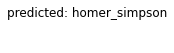

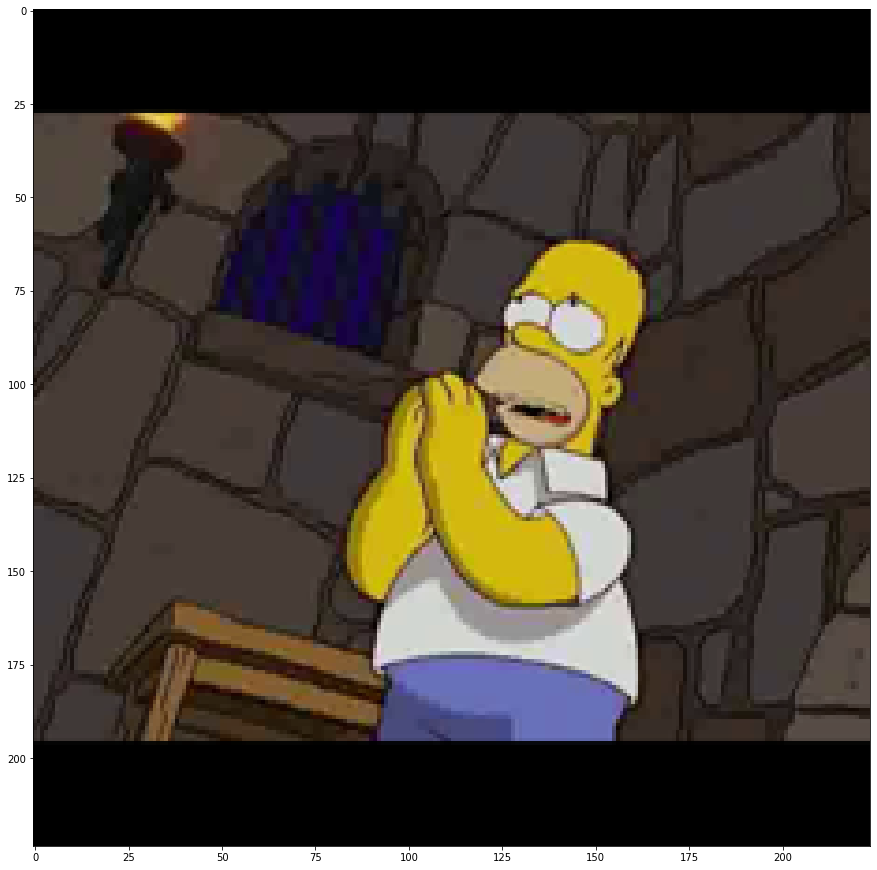

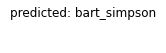

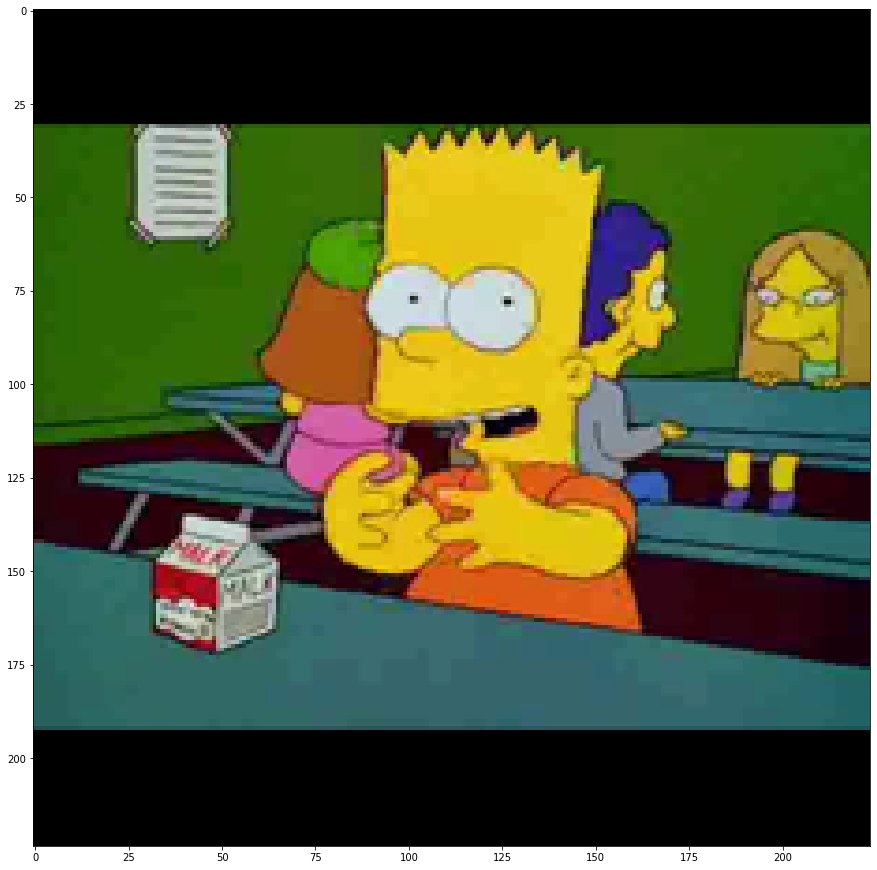

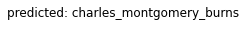

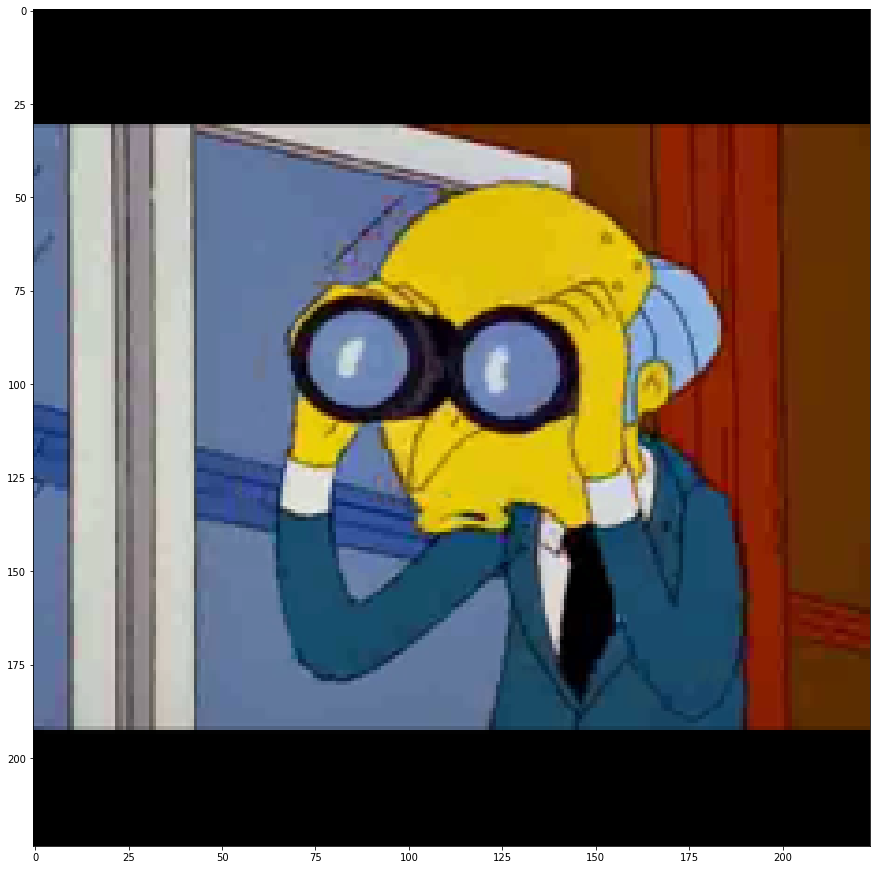

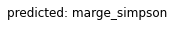

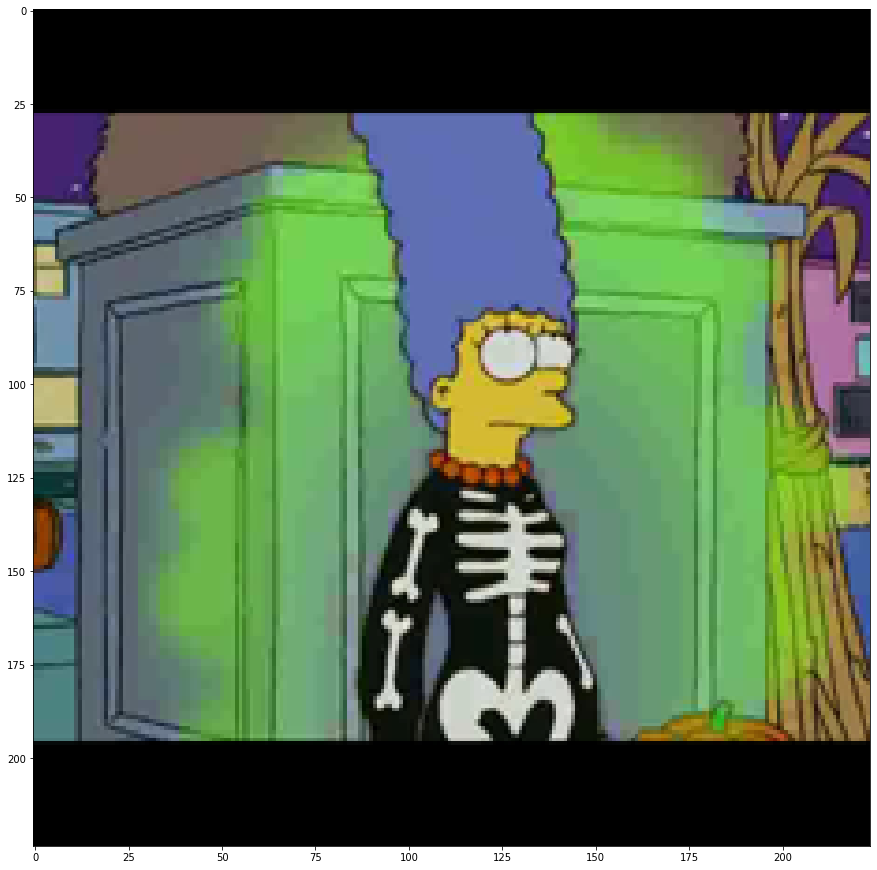

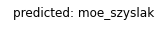

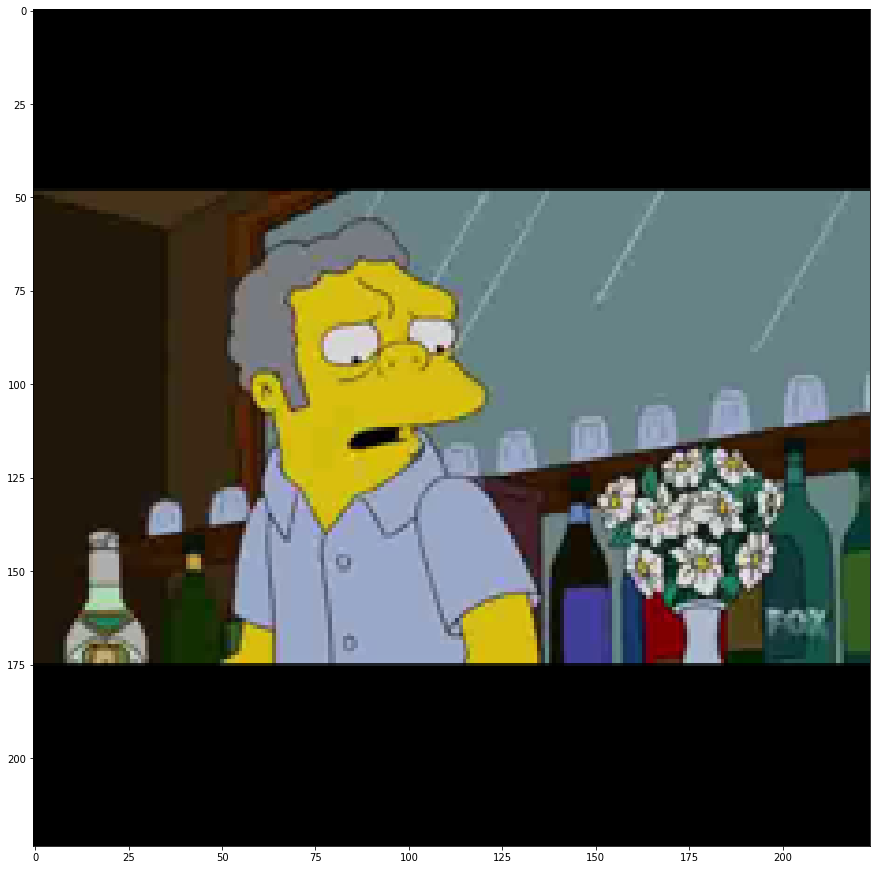

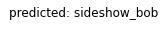

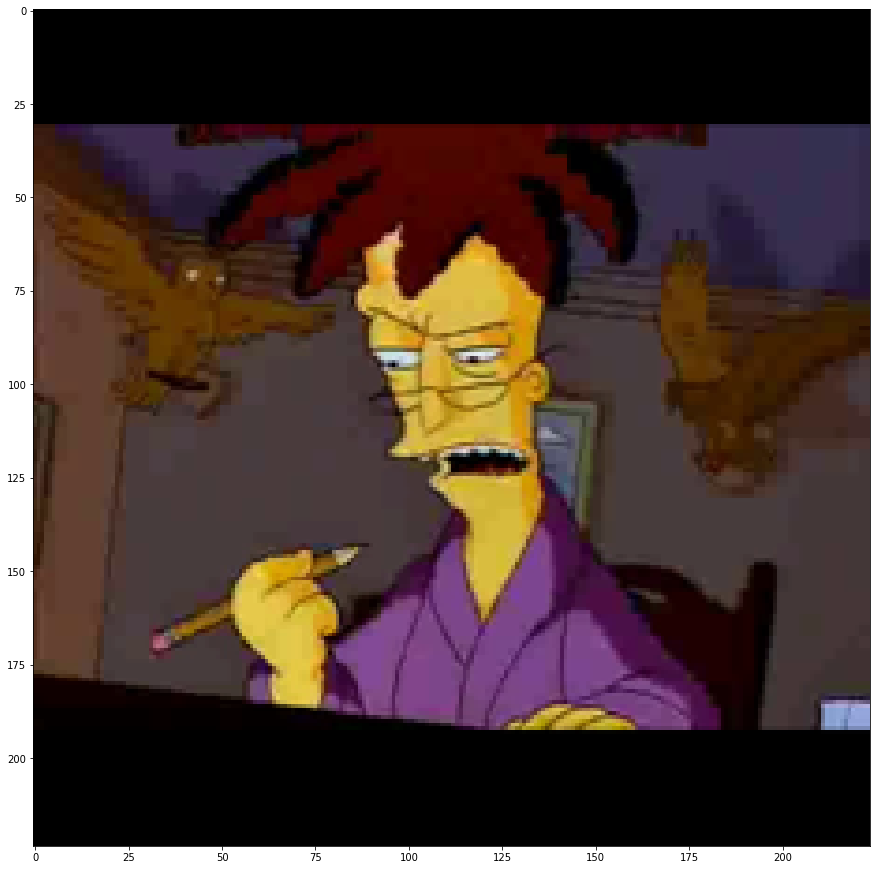

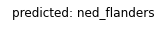

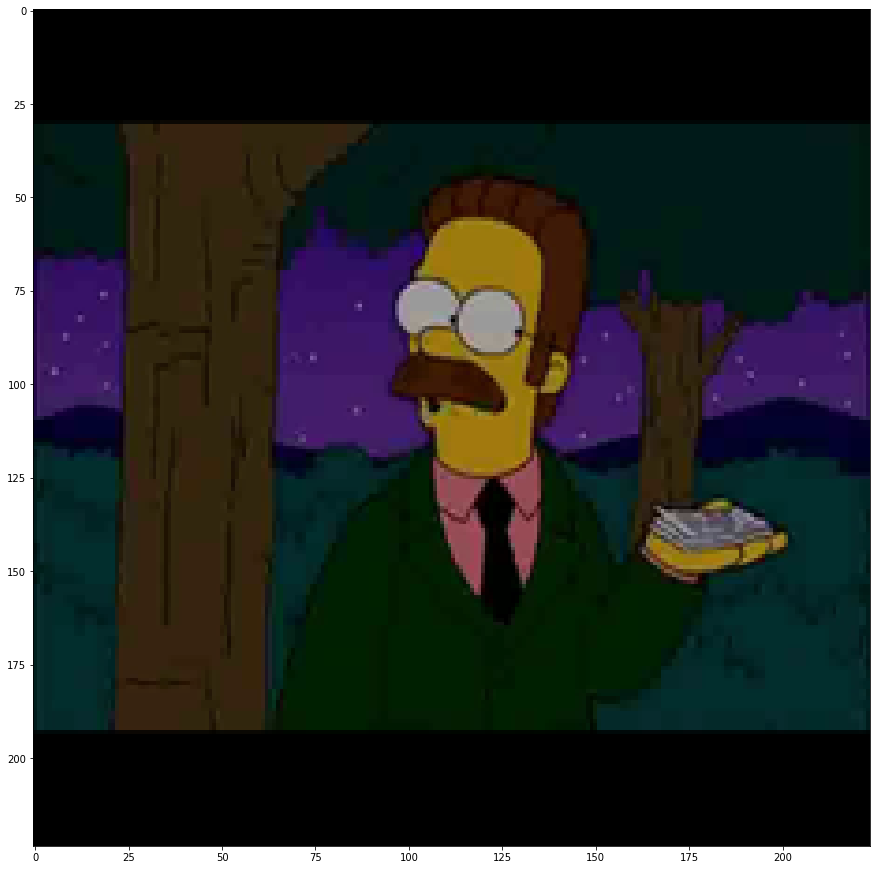

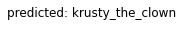

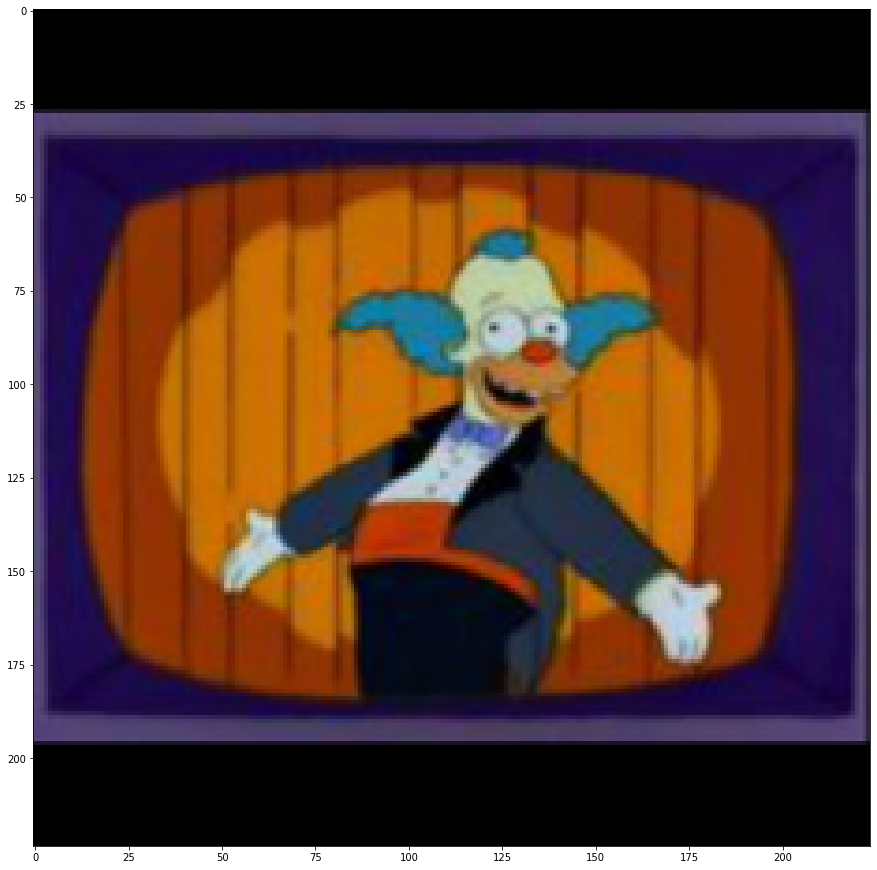

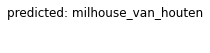

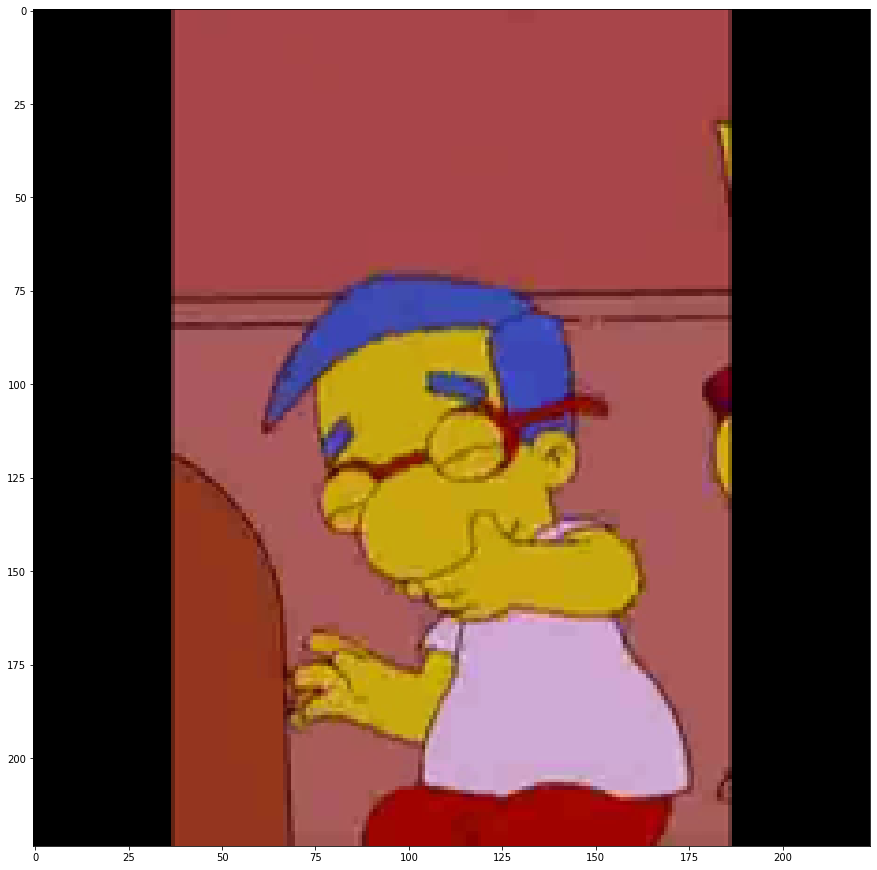

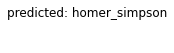

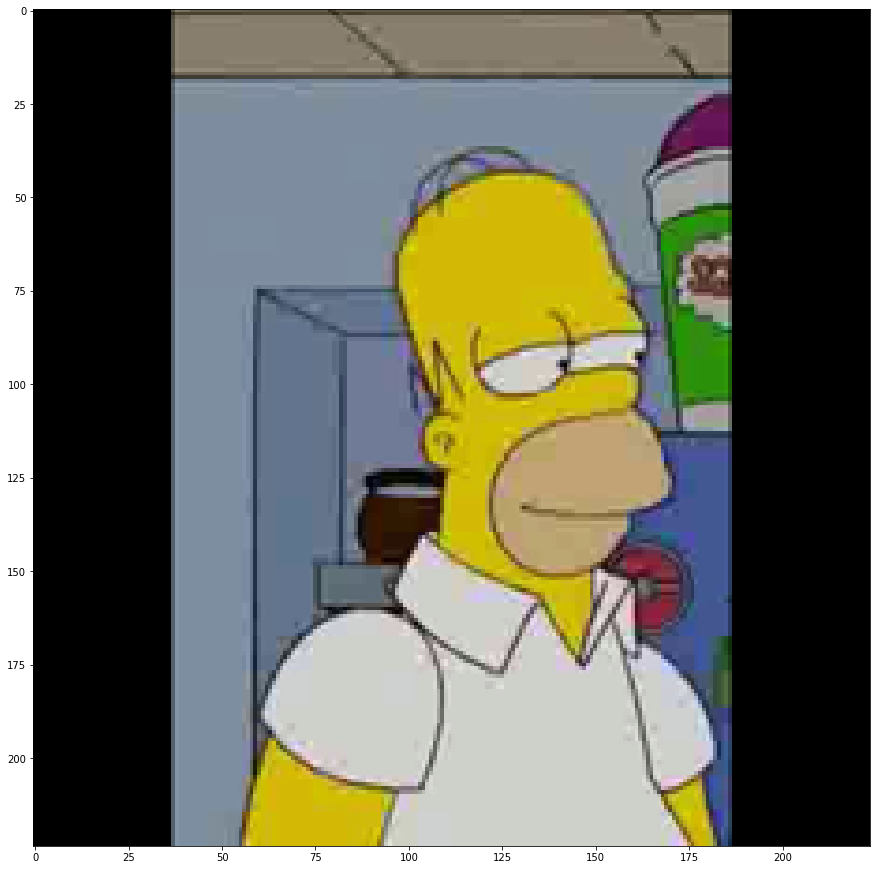

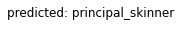

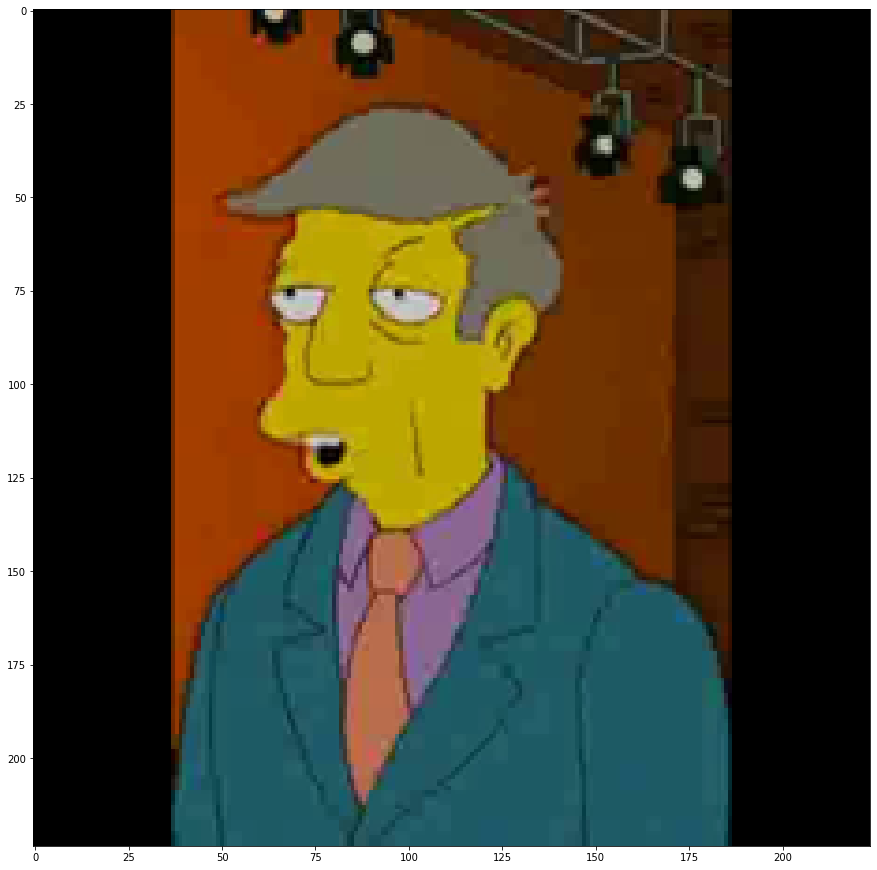

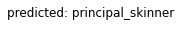

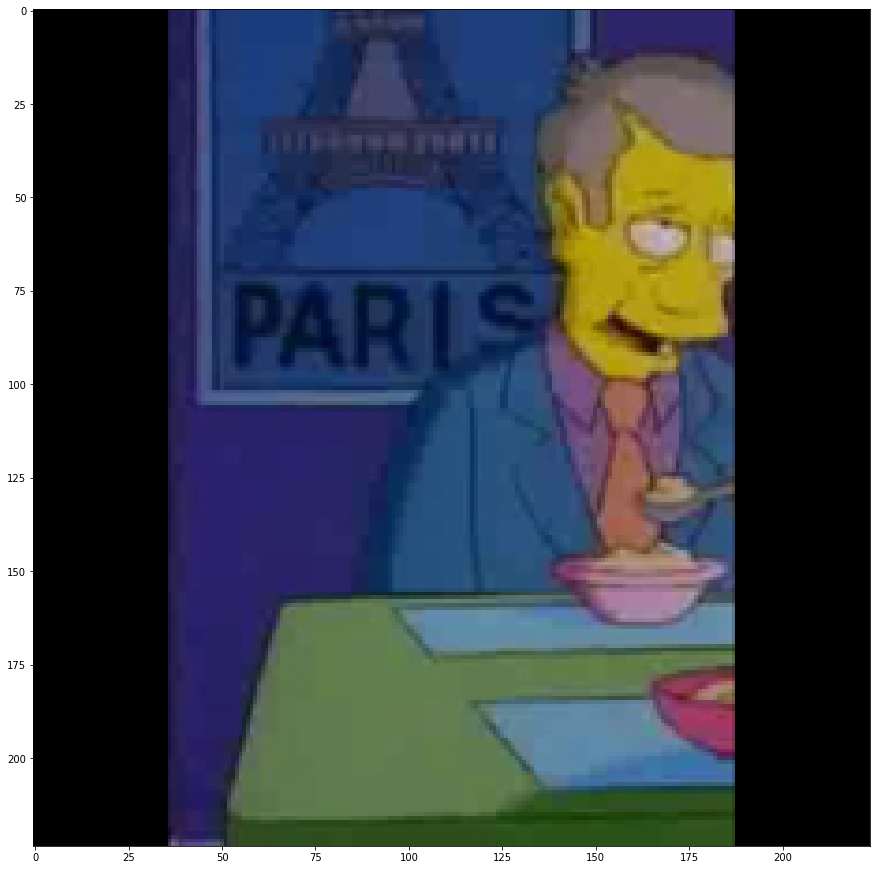

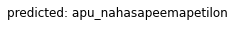

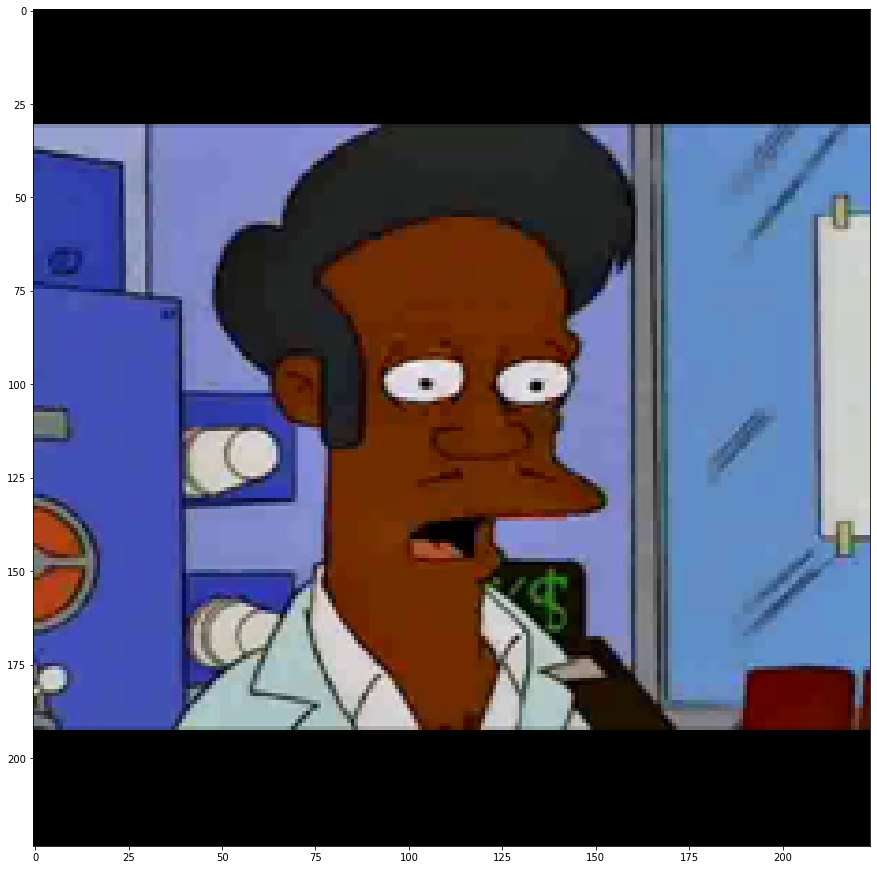

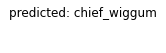

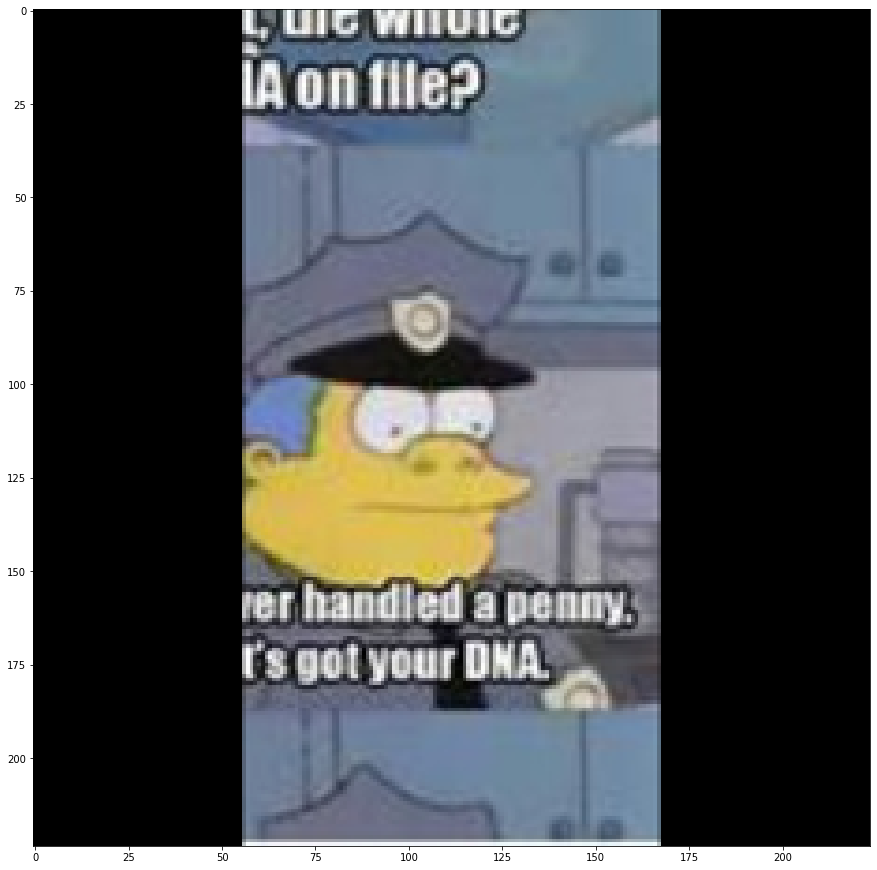

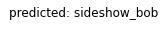

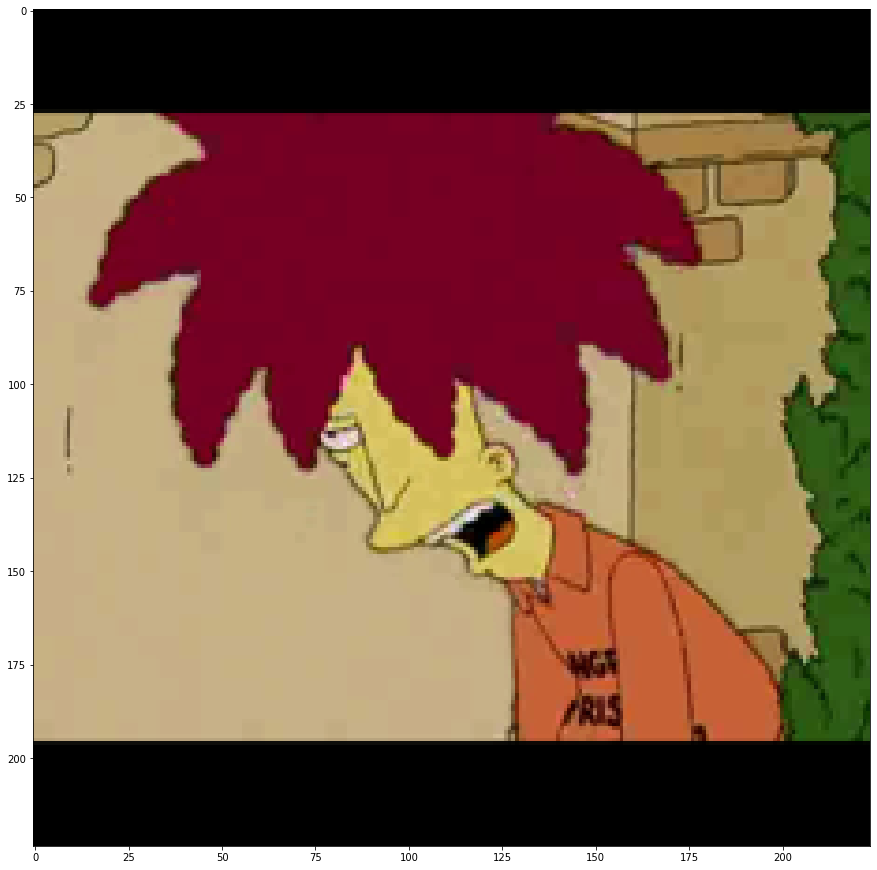

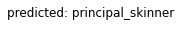

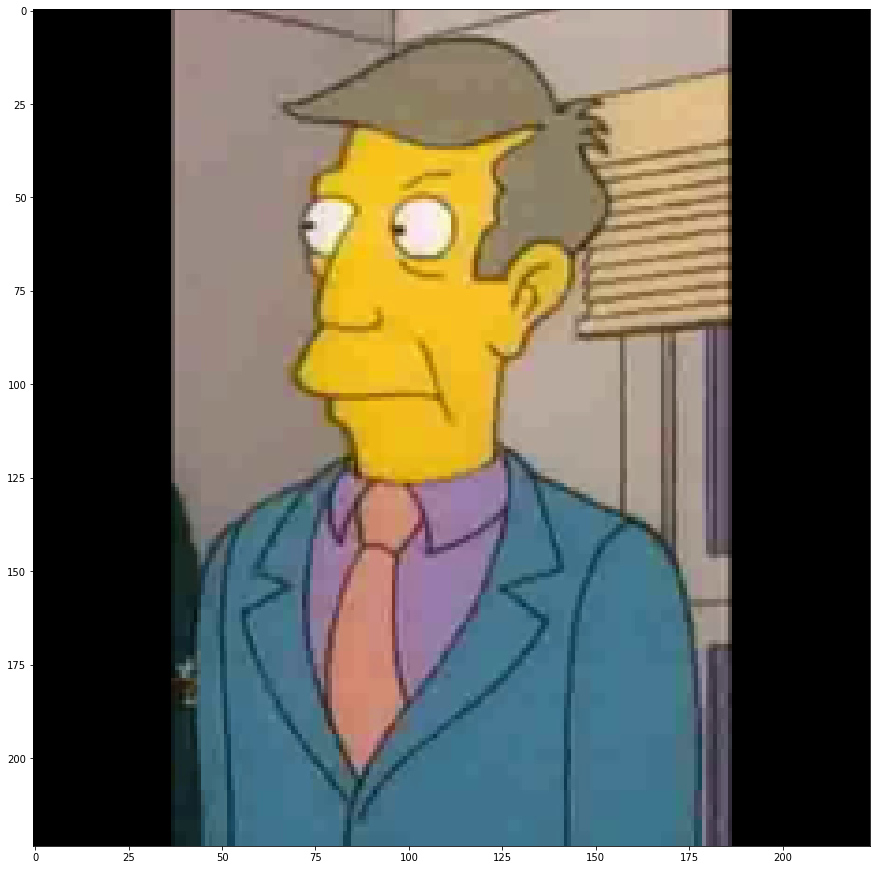

In [ ]:
visualize_model(model_ft)

In [ ]:
# Сохранение модели
torch.save(model_ft.state_dict(), './model')

In [ ]:
# Тестирование модели
test_dataset = torchvision.datasets.ImageFolder(root='./testset', transform=data_transforms['val'])

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

In [ ]:
# Загрузка мдели после перерыва
model_ft = torchvision.models.resnet18()

In [ ]:
model_ft.fc = nn.Linear(512, 42)

In [ ]:
model = torch.load('./model', map_location=torch.device('cpu'))
model_ft.load_state_dict(model)

<All keys matched successfully>

In [ ]:
# Предсказание
prediction = []
model_ft.eval()

with torch.no_grad():

  for inputs in test_loader:

    outputs = model_ft(inputs[0])
    _, preds = torch.max(outputs, 1)
    
    prediction.append(class_names[preds])



In [ ]:
prediction

['nelson_muntz',
 'bart_simpson',
 'ned_flanders',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'kent_brockman',
 'edna_krabappel',
 'chief_wiggum',
 'lisa_simpson',
 'kent_brockman',
 'lenny_leonard',
 'marge_simpson',
 'kent_brockman',
 'ned_flanders',
 'moe_szyslak',
 'comic_book_guy',
 'abraham_grampa_simpson',
 'edna_krabappel',
 'kent_brockman',
 'lisa_simpson',
 'marge_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'mayor_quimby',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'krusty_the_clown',
 'krusty_the_clown',
 'ned_flanders',
 'edna_krabappel',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'ned_flanders',
 'marge_simpson',
 'abraham_grampa_simpson',
 'homer_simpson',
 'sideshow_bob',
 'lisa_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'kent_brockman',
 'abraham_grampa_simpson',
 'milhouse_van_houten',
 'lenny_leonard',
 'abraham_grampa_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'chief_wiggum',
 'nelson_muntz',
 'mayor_quimby',
 'c

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
TEST_DIR = Path('testset/testset')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_filenames = [path.name for path in test_dataset.files]

Ник на Kaggle: Денис_Деменков

Score: 0.99256

https://www.kaggle.com/competitions/journey-springfield/leaderboard